In [1]:
import pandas as pd
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

In [2]:
cleaned = pd.read_csv('datasets/cleaned_Izends_Data_Thru201712_ver5.csv',index_col=0)

/home/ambuj/izenda_fullcycle/environment/env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cleaned_loss_des = pd.read_csv('hashed_cleaned_loss_desc_from_5_ipynb.csv',index_col=0)
# changing dtype of hashed_loss_desc_padded column
cleaned_loss_des['hashed_loss_desc_padded'] = cleaned_loss_des['hashed_loss_desc_padded'].apply(lambda x: np.fromstring(x[1:-1],dtype='int32',sep=' '))

# Changing bins from 10 to 5

In [4]:
cleaned_loss_des['EstimateTotal_bins'] = pd.qcut(cleaned['EstimateTotal'],2,labels = ["a", "b"])

In [5]:
cleaned_combined = pd.merge(cleaned,cleaned_loss_des[['EstimateTotal_bins','hashed_loss_desc_padded']],left_index=True,right_index=True)

In [6]:
cleaned_combined.shape

(766408, 28)

In [7]:
cleaned_combined.columns

Index(['DisplayName', 'DivisionName', 'City', 'Zip', 'State', 'LossYearMo',
       'StartedFlag', 'CommOrRes', 'NoteCount', 'PhotoCount', 'JobCount',
       'ClaimCount', 'EstimateTotal', 'PolicyHolderType', 'LossDescription',
       'Estimate_NetClaim', 'Estimate_MaterialSaleTax', 'Estimate_OverHead',
       'Estimate_Profit', 'Estimate_PctOverhead', 'Estimate_PctProfit',
       'Estimate_Deductible', 'Estimate_BaseSvcCharge',
       'CleanAddressFranchisorID', 'CleanAddressContactID', 'LossMo',
       'EstimateTotal_bins', 'hashed_loss_desc_padded'],
      dtype='object')

# Defining X and Y

In [8]:
X1 = cleaned_combined[['DisplayName', 'DivisionName','LossMo','CommOrRes','PolicyHolderType','NoteCount','PhotoCount','JobCount','ClaimCount','LossYearMo']]
X2 = cleaned_combined['hashed_loss_desc_padded']
y = cleaned_combined['EstimateTotal_bins']

# Getting Dummies

In [9]:
X1_dummies = pd.get_dummies(X1,sparse=True)

In [10]:
all_data = pd.merge(X1_dummies,pd.DataFrame(X2),left_index=True,right_index=True)
all_data['EstimateTotal_bins'] = y

# Splitting data

In [11]:
test2017=all_data[all_data["LossYearMo"].apply(lambda all_data:all_data>=201701)]
learning=all_data[all_data["LossYearMo"].apply(lambda all_data:all_data<201701)]

In [12]:
learning_x = learning[learning.columns.difference(['LossYearMo','EstimateTotal_bins'])]
learning_y = learning['EstimateTotal_bins']
learning_y_dummies = pd.get_dummies(learning_y,sparse=True)

In [13]:
test2017_x1 = test2017[test2017.columns.difference(['LossYearMo','EstimateTotal_bins','hashed_loss_desc_padded'])]
test2017_x2 = test2017['hashed_loss_desc_padded']
test2017_y = test2017['EstimateTotal_bins']
test2017_y_dummies = pd.get_dummies(test2017_y,sparse=True)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(learning_x, learning_y_dummies, test_size=0.33, random_state=42)

In [15]:
X1_train = X_train[X_train.columns.difference(['hashed_loss_desc_padded'])]
X2_train = X_train['hashed_loss_desc_padded']

In [16]:
X1_val = X_val[X_val.columns.difference(['hashed_loss_desc_padded'])]
X2_val = X_val['hashed_loss_desc_padded']

# Building Custom Keras Combined Model using Functional API

In [18]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, History 
from keras.layers.merge import concatenate

Using TensorFlow backend.


In [19]:
# first input
input1 = Input(shape=(X1_train.shape[1],),name='input1')

In [20]:
# second input
input2 = Input(shape=(14,),name='input2')
embedding = Embedding(11024,100,input_length=14)(input2)
lstm = LSTM(15)(embedding)

In [21]:
# merge layers
merge = concatenate([input1,lstm])

In [22]:
hidden1 = Dense(512, activation='relu')(merge)
dropout1 = Dropout(0.25)(hidden1)
hidden2 = Dense(512, activation='relu')(dropout1)
dropout2 = Dropout(0.25)(hidden2)

In [23]:
# output layer
output = Dense(y_train.shape[1], activation='softmax',name='output')(dropout2)

In [24]:
# Model
model = Model(inputs=[input1,input2], outputs=output)

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             (None, 14)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 14, 100)      1102400     input2[0][0]                     
__________________________________________________________________________________________________
input1 (InputLayer)             (None, 1064)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 15)           6960        embedding_1[0][0]                
__________________________________________________________________________________________________
concatenat

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

In [28]:
model.fit({'input1':X1_train,'input2':np.stack(X2_train, axis=0)},
          {'output':y_train.values},
          validation_data=({'input1':X1_val,'input2':np.stack(X2_val, axis=0)},{'output':y_val.values}),
         callbacks=[early_stop],epochs=500, batch_size=128,verbose=1)

Train on 335176 samples, validate on 165087 samples
Epoch 1/500
335176/335176 [==============================] - 83s 246us/step - loss: 0.5702 - acc: 0.7027 - val_loss: 0.5438 - val_acc: 0.7222
Epoch 2/500
335176/335176 [==============================] - 81s 242us/step - loss: 0.5326 - acc: 0.7303 - val_loss: 0.5399 - val_acc: 0.7232
Epoch 3/500
335176/335176 [==============================] - 81s 242us/step - loss: 0.5166 - acc: 0.7422 - val_loss: 0.5364 - val_acc: 0.7259
Epoch 4/500
335176/335176 [==============================] - 81s 242us/step - loss: 0.5009 - acc: 0.7521 - val_loss: 0.5512 - val_acc: 0.7200
Epoch 5/500
335176/335176 [==============================] - 81s 242us/step - loss: 0.4869 - acc: 0.7606 - val_loss: 0.5499 - val_acc: 0.7220
Epoch 6/500
335176/335176 [==============================] - 81s 242us/step - loss: 0.4716 - acc: 0.7693 - val_loss: 0.5790 - val_acc: 0.7221
Epoch 7/500
335176/335176 [==============================] - 81s 242us/step - loss: 0.4577 - acc

# Running simulations for different thresholds

In [29]:
test2017_preds_proba = model.predict({'input1':test2017_x1,'input2':np.stack(test2017_x2, axis=0)})

In [30]:
t = pd.DataFrame(test2017_preds_proba)

In [31]:
result_df = pd.DataFrame(columns=['thresh','no_of_preds','total_preds','pct_of_preds','accuracy'])

for thresh in [.02,0.04,0.06,0.08,0.1,0.15,0.20,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    temp_df = pd.DataFrame(columns=['thresh','no_of_preds','total_preds','pct_of_preds','accuracy'])
    a = t[t > thresh]
    test2017_preds = np.array(a.idxmax(axis=1))
    mapping_dict = {0.0:'a',1.0:'b',np.nan:'k'}
    test2017_preds_names = pd.Series(test2017_preds).map(mapping_dict)
    pct_of_preds = len(test2017_preds_names[test2017_preds_names != 'k']) / len(test2017_preds_names) * 100
    
    final_df = pd.merge(pd.DataFrame(test2017_y).reset_index(drop=True),pd.DataFrame(test2017_preds_names),left_index=True,right_index=True)
    final_df = final_df[final_df[0] != 'k']
    
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(final_df['EstimateTotal_bins'],final_df[0])
    temp_df.at[0,'thresh'] = thresh
    temp_df.at[0,'no_of_preds'] = len(test2017_preds_names[test2017_preds_names != 'k'])
    temp_df.at[0,'total_preds'] = len(test2017_preds_names)
    temp_df.at[0,'pct_of_preds'] = pct_of_preds
    temp_df.at[0,'accuracy'] = acc
    result_df = result_df.append(temp_df)

/home/ambuj/izenda_fullcycle/environment/env/lib/python3.5/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/ambuj/izenda_fullcycle/environment/env/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
result_df

,thresh,no_of_preds,total_preds,pct_of_preds,accuracy
0,0.02,266145,266145,100,0.728531
0,0.04,266145,266145,100,0.728531
0,0.06,266145,266145,100,0.728531
0,0.08,266145,266145,100,0.728531
0,0.1,266145,266145,100,0.728531
0,0.15,266145,266145,100,0.728531
0,0.2,266145,266145,100,0.728531
0,0.25,266145,266145,100,0.728531
0,0.3,266145,266145,100,0.728531
0,0.4,266145,266145,100,0.728531


### Cnonfusion Matrix

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [34]:
test2017_preds_cm = np.argmax(test2017_preds_proba,axis=1)
mapping_dict_cm = {0:'a',1:'b'}
test2017_preds_names_cm = pd.Series(test2017_preds_cm).map(mapping_dict_cm)

In [35]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap =sns.cm.rocket_r)
    plt.show()

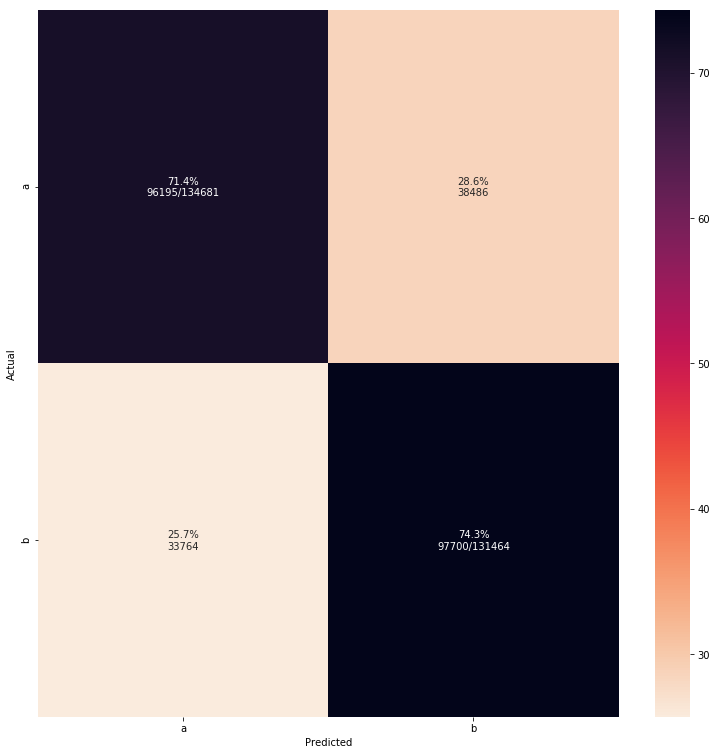

In [36]:
cm_analysis(test2017_y,test2017_preds_names_cm, list(mapping_dict_cm.values()), ymap=None, figsize=(13,13))

In [37]:
test2017_y.value_counts()

a    134681
b    131464
Name: EstimateTotal_bins, dtype: int64

In [39]:
bin_df = pd.DataFrame(pd.qcut(cleaned_loss_des['EstimateTotal'],2).value_counts().sort_index(ascending=True))
bin_df.reset_index(inplace=True)
bin_df.columns = ['range','count']
bin_df['category'] = list(mapping_dict_cm.values())
bin_df

,range,count,category
0,"(-0.0009999999999716, 2790.16]",383204,a
1,"(2790.16, 265738.05]",383204,b
